In [97]:
import os
import matplotlib.pyplot as plt
import glob
import h5py
import shutil
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
from PIL import Image
from pathlib import Path
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import cv2
import keras
import pandas as pd
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import DenseNet169, DenseNet121, DenseNet201
import tensorflow as tf

In [72]:
import numpy as np
import sys
import os
import PIL
import PIL.Image as Image
import seaborn as sns
import warnings
import nibabel as nib
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from dltk.io.preprocessing import whitening
from dltk.io.augmentation import flip
import time
print('All imported!')

All imported!


In [73]:
img_directory = 'dataset'
dataset_info = pd.read_excel('IXI.xls')
dataset_info.head()

,IXI_ID,"SEX_ID (1=m, 2=f)",HEIGHT,WEIGHT,ETHNIC_ID,MARITAL_ID,OCCUPATION_ID,QUALIFICATION_ID,DOB,DATE_AVAILABLE,STUDY_DATE,AGE
0,2,2,164,58,1,4,1,5,1970-01-30,1,2005-11-18,35.800137
1,12,1,175,70,1,2,1,5,1966-08-20,1,2005-06-01,38.781656
2,13,1,182,70,1,2,1,5,1958-09-15,1,2005-06-01,46.710472
3,14,2,163,65,1,4,1,5,1971-03-15,1,2005-06-09,34.236824
4,15,1,181,90,2,1,6,5,1981-03-11,1,2005-06-23,24.284736


### Processing the data

In [74]:
# reading the MRI images with nibabel and
# identifying file names that are not mentioned in the EXCEL file

image_files = []
labels = []
not_included = []
for filename in os.listdir(img_directory):
    try:
        # reading the label from Excel
        img_id = int(filename[3:6])
        sex = np.array(dataset_info[dataset_info.IXI_ID == img_id])[0][1]
        labels.append(sex-1)
        # reading images
        img = nib.load(img_directory+"/"+filename)
        image_files.append(img)
    except Exception as e:
#         print(e)
        not_included.append(filename)
        
len(not_included)

15

In [75]:
len(image_files), len(labels)

(566, 566)

In [76]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(image_files, labels, test_size=0.2,
                                                    random_state =1, stratify = labels )

len(X_train), len(X_test)

(452, 114)

In [188]:
def count_class(labels):
    zero = 0
    one = 0
    for l in labels:
        if l == 0:
             zero += 1
        else:
            one += 1
    return zero, one, zero/ one

A:\anaconda3\envs\tf\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


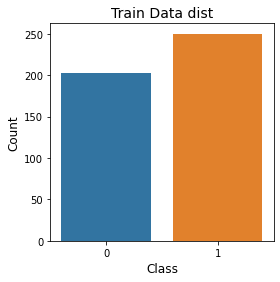

(202, 250, 0.808)


A:\anaconda3\envs\tf\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


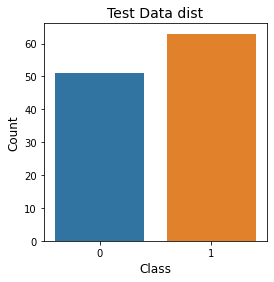

(51, 63, 0.8095238095238095)


In [189]:
from seaborn import countplot

# Plot the results 
plt.figure(figsize=(4,4))
c1 = countplot(y_train)
plt.title('Train Data dist', fontsize=14)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Class', fontsize=12)
plt.show()
print(count_class(y_train))

plt.figure(figsize=(4,4))
c2 = countplot(y_test)
plt.title('Test Data dist', fontsize=14)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Class', fontsize=12)
plt.show()

print(count_class(y_test))

In [ ]:
from sklearn.utils import class_weight
weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)

(256, 256, 150)


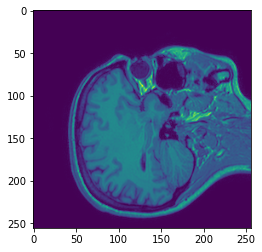

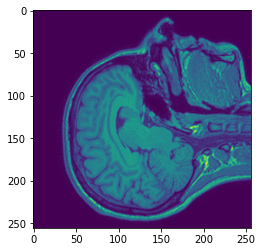

In [193]:
img = np.array(image_files[0].dataobj)
print(img.shape)
img = flip(img, axis=1)
plt.imshow(img[:,:, 50])
plt.show()
plt.imshow(img[:,:, 80])
plt.show()

In [194]:
# showing a progressbar in output
def progressBar(value, endvalue, bar_length=20,job='Job'):

    percent = float(value) / endvalue
    arrow = '-' * int(round(percent * bar_length)-1) + '>'
    spaces = ' ' * (bar_length - len(arrow))

    sys.stdout.write("\r{0} Completion: [{1}] {2}%".format(job,arrow + spaces, int(round(percent * 100))))
    sys.stdout.flush()

### Defining the generator

In [195]:
in_size = 256; in_dim = 3

In [163]:
def process_images(images, method = None, channels = 150):#, resize= False, resize_scale = 2):
    
    data = []
    j = 1
    
    for img_ in images:
        try:
            progressBar(j, len(images), bar_length=20, job='Job')
            
##             rescaling the image, although the problem is the output images does not have the same size
#             if resize:
#                 img = resample_img(img, target_affine=np.eye(3)*resize_scale, interpolation='nearest')
#                 print(img.shape)
            
            img = np.array(img_.dataobj)
            dx , dy = img.shape[0], img.shape[1]
            
            # add zero channels to images with fewer channels than others
            if method == 'add_channels':
                dz = 150
                if img.shape[2] != 150:
                    img = np.concatenate((img, np.zeros((img.shape[0],img.shape[1],150-img.shape[2]))), axis =2)
            elif method == 'del_channels':
                dz = channels
                if dz%2 == 0:
                    img = img[:,:,75 - (channels//2) :75 + (channels//2)]
                else:
                    img = img[:,:,74 - (channels//2) +1 :76 + (channels//2)]

            img = whitening(img)
            
            data.append(img)
            j += 1
        except Exception as e:
            print(filename)
            print(e)
            
    return np.array(data).reshape(-1, dx, dy, dz)                

In [164]:
X_train_processed= process_images(X_train, method = 'del_channels',channels = in_dim)

Job Completion: [------------------->] 100%

In [165]:
X_train_processed.shape

(452, 256, 256, 3)

In [166]:
X_test_processed= process_images(X_test, method = 'del_channels',channels = in_dim)

Job Completion: [------------------->] 100%

In [167]:
X_test_processed.shape

(114, 256, 256, 3)

In [169]:
datagen = ImageDataGenerator(rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,                         
    horizontal_flip=False)

In [203]:
y_train = np.array(y_train).reshape(len(y_train),1)
y_test = np.array(y_test).reshape(len(y_test),1)

### Defining the model

In [304]:
transfer_lr = True; base_weights = 'imagenet' ; bs = 32; reg = False; penalty = 0
# transfer_lr = False; base_weights = None; bs = 16.

train_gen = datagen.flow(X_train_processed, y_train, batch_size=bs)

In [305]:
# if transfer learning is enabled, we freeze everything except the last layer

base_model = DenseNet169(weights= base_weights, include_top=False,
                         input_shape=(in_size, in_size, in_dim), pooling='avg')

base_model.trainable = not transfer_lr

inputs = Input(shape=(in_size, in_size, in_dim))
    
x = base_model(inputs, training = not transfer_lr)

outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs, outputs)

model.summary()

Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_41 (InputLayer)        [(None, 256, 256, 3)]     0         
_________________________________________________________________
densenet169 (Model)          (None, 1664)              12642880  
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 1665      
Total params: 12,644,545
Trainable params: 1,665
Non-trainable params: 12,642,880
_________________________________________________________________


In [307]:
steps = len(X_train_processed) // bs

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.1, patience=3, verbose=1,
    mode='auto', min_delta=0.001, cooldown=0, min_lr=1e-8)


chkpt = ModelCheckpoint(filepath='weights/', save_best_only=True,
                        save_weights_only=True, monitor= 'val_accuracy', mode='max')

initial_learning_rate = 3e-3
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=steps,
    decay_rate=0.9,
    staircase=True)

opt = Adam(learning_rate=lr_schedule) 

In [308]:
model.compile(loss= 'binary_crossentropy', metrics=['accuracy'], optimizer=opt)

In [309]:
start = time.time()

nb_epochs = 20 

# Fit the model
history= model.fit(train_gen, epochs= nb_epochs, steps_per_epoch= steps,
                              validation_data=(X_test_processed, y_test),
                              callbacks=[chkpt], #, [chkpt, clr, es , reduce_lr]
                              class_weight=weights)
end = time.time()

print('*'*40)
print('Took {:.2f} minutes'. format((end-start)/60))

  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 14 steps, validate on 114 samples
Epoch 1/20
14/14 [==============================] - 19s 1s/step - loss: 0.7480 - accuracy: 0.5262 - val_loss: 0.6085 - val_accuracy: 0.6491
Epoch 2/20
14/14 [==============================] - 6s 421ms/step - loss: 0.6185 - accuracy: 0.6714 - val_loss: 0.5497 - val_accuracy: 0.7982
Epoch 3/20
14/14 [==============================] - 5s 386ms/step - loss: 0.5713 - accuracy: 0.7214 - val_loss: 0.5472 - val_accuracy: 0.6228
Epoch 4/20
14/14 [==============================] - 5s 385ms/step - loss: 0.5183 - accuracy: 0.7762 - val_loss: 0.4990 - val_accuracy: 0.7632
Epoch 5/20
14/14 [==============================] - 6s 419ms/step - loss: 0.4964 - accuracy: 0.7833 - val_loss: 0.4584 - val_accuracy: 0.8070
Epoch 6/20
14/14 [==============================] - 6s 425ms/step - loss: 0.4992 - accuracy: 0.7881 - val_loss: 0.4390 - val_accuracy: 0.8684
Epoch 7/20
14/14 [==============================] - 6s 415ms/step - loss: 0.4814 - accuracy: 0.7946 - val_

Best train acc: 0.8785714507102966 | Best val acc: 0.8859649300575256 


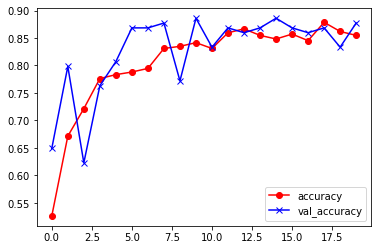

In [310]:
print('Best train acc: {} | Best val acc: {} '.format(max(history.history['accuracy']),
                                                      max(history.history['val_accuracy'])))
plt.plot(history.history['accuracy'],'ro-')
plt.plot(history.history['val_accuracy'],'bx-')
plt.legend(['accuracy','val_accuracy'])
plt.show()

In [311]:
model.load_weights('weights/')
model.evaluate(X_test_processed, y_test)

114/114 [==============================] - ETA: 0s - loss: 0.4048 - accuracy: 0.88 - 1s 4ms/sample - loss: 0.3915 - accuracy: 0.8860


[0.39154063348184553, 0.88596493]

### Fine tune

In [315]:
bs = 8
steps = len(X_train_processed) // bs
train_gen = datagen.flow(X_train_processed, y_train, batch_size=bs)

base_model.trainable = True

# in fintuning if you dont lower the LR the weight update 
# will be very rapid and the result is poor
initial_learning_rate = 5e-7
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=steps,
    decay_rate=0.9,
    staircase=True)

opt = Adam(learning_rate=lr_schedule) 

model.compile(loss= 'binary_crossentropy', metrics=['accuracy'], optimizer=opt)

In [317]:
start = time.time()

nb_epochs = 15 

# Fit the model
history= model.fit(train_gen, epochs= nb_epochs, steps_per_epoch= steps,
                              validation_data=(X_test_processed, y_test),
                              callbacks=[chkpt],
                              class_weight=weights)
end = time.time()

print('*'*40)
print('Took {:.2f} minutes'. format((end-start)/60))

  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 56 steps, validate on 114 samples
Epoch 1/15
56/56 [==============================] - 27s 484ms/step - loss: 0.4195 - accuracy: 0.8446 - val_loss: 0.3708 - val_accuracy: 0.8860
Epoch 2/15
56/56 [==============================] - 10s 181ms/step - loss: 0.3883 - accuracy: 0.8559 - val_loss: 0.3696 - val_accuracy: 0.8596
Epoch 3/15
56/56 [==============================] - 10s 182ms/step - loss: 0.3688 - accuracy: 0.8694 - val_loss: 0.3396 - val_accuracy: 0.8772
Epoch 4/15
56/56 [==============================] - 10s 182ms/step - loss: 0.3590 - accuracy: 0.8671 - val_loss: 0.3240 - val_accuracy: 0.8772
Epoch 5/15
56/56 [==============================] - 10s 183ms/step - loss: 0.3444 - accuracy: 0.8784 - val_loss: 0.3226 - val_accuracy: 0.8772
Epoch 6/15
56/56 [==============================] - 10s 183ms/step - loss: 0.3498 - accuracy: 0.8851 - val_loss: 0.3003 - val_accuracy: 0.8772
Epoch 7/15
56/56 [==============================] - 10s 183ms/step - loss: 0.3480 - accuracy: 0.86

Best train acc: 0.912162184715271 | Best val acc: 0.8859649300575256 


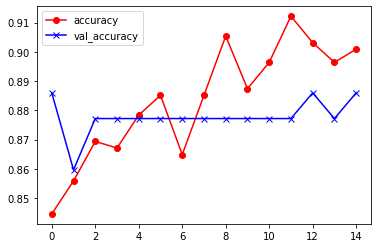

In [318]:
print('Best train acc: {} | Best val acc: {} '.format(max(history.history['accuracy']),
                                                      max(history.history['val_accuracy'])))
plt.plot(history.history['accuracy'],'ro-')
plt.plot(history.history['val_accuracy'],'bx-')
plt.legend(['accuracy','val_accuracy'])
plt.show()

In [319]:
start = time.time()

nb_epochs = 15 

# Fit the model
history= model.fit(train_gen, epochs= nb_epochs, steps_per_epoch= steps,
                              validation_data=(X_test_processed, y_test),
                              callbacks=[chkpt],
                              class_weight=weights)
end = time.time()

print('*'*40)
print('Took {:.2f} minutes'. format((end-start)/60))

  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 56 steps, validate on 114 samples
Epoch 1/15
56/56 [==============================] - 11s 196ms/step - loss: 0.2699 - accuracy: 0.9099 - val_loss: 0.2510 - val_accuracy: 0.9035
Epoch 2/15
56/56 [==============================] - 10s 179ms/step - loss: 0.2689 - accuracy: 0.9077 - val_loss: 0.2532 - val_accuracy: 0.8860
Epoch 3/15
56/56 [==============================] - 10s 179ms/step - loss: 0.2872 - accuracy: 0.9009 - val_loss: 0.2515 - val_accuracy: 0.8860
Epoch 4/15
56/56 [==============================] - 10s 178ms/step - loss: 0.2869 - accuracy: 0.8896 - val_loss: 0.2518 - val_accuracy: 0.8860
Epoch 5/15
56/56 [==============================] - 10s 178ms/step - loss: 0.2879 - accuracy: 0.8986 - val_loss: 0.2482 - val_accuracy: 0.8860
Epoch 6/15
56/56 [==============================] - 10s 179ms/step - loss: 0.2700 - accuracy: 0.9077 - val_loss: 0.2511 - val_accuracy: 0.8772
Epoch 7/15
56/56 [==============================] - 10s 179ms/step - loss: 0.2519 - accuracy: 0.92

Best train acc: 0.9414414167404175 | Best val acc: 0.9035087823867798 


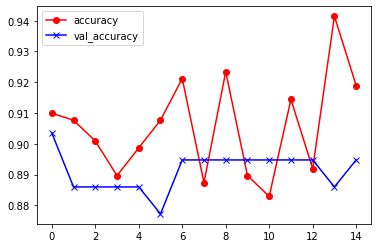

In [320]:
print('Best train acc: {} | Best val acc: {} '.format(max(history.history['accuracy']),
                                                      max(history.history['val_accuracy'])))
plt.plot(history.history['accuracy'],'ro-')
plt.plot(history.history['val_accuracy'],'bx-')
plt.legend(['accuracy','val_accuracy'])
plt.show()